# Khujta AI Business iypnb

## Propósito
Este notebook está diseñado para analizar datos transaccionales. Su objetivo es descubrir ideas accionables que optimicen las operaciones, el inventario y la generación de ingresos.

## Estructura
1. **Carga y Configuración de Datos**:
   - Importar bibliotecas y configurar variables.
   - Cargar el conjunto de datos y realizar verificaciones iniciales de integridad de datos.
2. **Análisis**:
   - Agregar datos para identificar los productos de mejor desempeño.
   - Aplicar el Principio de Pareto (regla 80/20) para resaltar los principales generadores de ingresos.
   - Visualizar la distribución de ingresos y métricas acumulativas.
   - Identificar inventario muerto y evaluar la salud del inventario.
   - Analizar patrones de ventas por día y hora.
3. **Resumen Ejecutivo**:
   - Consolidar las ideas clave en un tablero para los tomadores de decisiones.

## Valor
- **Optimización de Ingresos**: Enfocarse en los productos principales que generan la mayoría de los ingresos.
- **Reducción de Costos**: Destacar inventario muerto e ineficiencias para liberar efectivo y espacio de almacenamiento.
- **Eficiencia Operativa**: Optimizar horarios de personal y operaciones basados en patrones de ventas.
- **Decisiones Basadas en Datos**: Proporcionar ideas accionables para la planificación estratégica.

Este cuaderno transforma datos crudos en ideas significativas, permitiendo una toma de decisiones informada y mejoras comerciales medibles.

# 1. Inicialización

Esta sección se centra en cargar y preparar los datos para el análisis. Mapearemos las columnas, cargaremos el conjunto de datos y realizaremos verificaciones iniciales para garantizar que los datos estén listos para una exploración más profunda.

## 1.1. Configurar Variables

Mapear las columnas asegura que el script pueda interpretar correctamente el conjunto de datos. Ajuste los nombres de las columnas según sea necesario para que coincidan con la estructura del conjunto de datos.

### 1.1.0. Configuración del Cuaderno
Antes de profundizar en el análisis, definimos variables y funciones clave. Esto asegura consistencia y claridad en todo el cuaderno.

<b>Generalmente no tocar, los ajustes de depuración se realizan aquí.</b>

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime, timedelta
pd.set_option('display.float_format', '{:.0f}'.format)

# Function to print debug information for a DataFrame
def debug_dataframe(df, dbg_flag = True, limit = 5):
    if dbg_flag:
        print(tabulate(df.head(limit), headers='keys', tablefmt='psql'))
        # print(df.head(limit).to_string())

# debug flags
dbg_setup = 0 # Changed to 1 to show setup info
dbg_load = 0 # Changed to 1 to show more info during load
dbg_analysis = 0 # Changed to 1 to show more info for analysis steps

### 1.1.1. MANUAL Cargar Variables

In [ ]:
## Manually set paths and filenames
data_path = 'data/'
project = 'buenacarne/'
file_in_name = 'sample_completeDet'

In [ ]:
today_str = datetime.today().strftime('%Y%m%d')
file_in = data_path + project + file_in_name
file_out = data_path + project + file_in_name + '_out_' + today_str

if dbg_setup:
    print(f"Input file names: {file_in}")
    print(f"Output file names: {file_out}")

### 1.1.2 MANUAL Variables de Análisis
Definir las variables y mapear las columnas asegura que el análisis esté adaptado al conjunto de datos. Ajuste estas configuraciones según sea necesario para que coincidan con sus datos.

In [ ]:
# Manually set Analysis parameters
# present_dt = pd.Timestamp.now() # Default Analysis date
present_dt = datetime(2018, 1, 21) # Change in case you want to analyze a specific date
top_prcnt = 0.2 # % of top products to consider as "top sellers"

# Columns mapping
transaction_id = 'trans_id' # unique transaction identifier
date_col = 'fecha' # Adjust based on actual column name
product_col = 'producto' # product identifier
description_col = 'glosa' # product description
cost_col = 'costo' # cost per item
revenue_col = 'total' # total revenue on a given item in a transaction
quantity_col = 'cantidad'# quantity sold of that item in a transaction
current_stock_col = np.nan # Placeholder for current stock column if available

In [ ]:
# Column groups
# List of amount columns to format
amount_cols = [revenue_col, 'revenue_cum']
# List of percentage columns to format
percentage_cols = ['revenue_pct_cum','quantity_pct_cum']

## 1.2. Cargar Datos

Aquí, cargamos el conjunto de datos y configuramos las bibliotecas necesarias para la manipulación y visualización de datos. Este paso es crucial para garantizar que los datos sean accesibles y estén correctamente formateados para el análisis.

In [ ]:
# Cargar datos
df = pd.read_csv(file_in + '.csv')
if dbg_load:
    debug_dataframe(df, dbg_load)

## 1.3. Verificar Integridad de los Datos

Este paso implica verificar valores faltantes y comprender la estructura del conjunto de datos. Identificar valores nulos temprano ayuda a limpiar los datos y garantizar un análisis preciso.

In [ ]:
# Set up nice visuals
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Quick data reconnaissance
if dbg_load: 
    print("Data shape:", df.shape)
    print(f"Columns({df.columns.size}):", df.columns.tolist())


In [ ]:
# Check data types and missing values
if dbg_load > 1: 
    print("Data Info:")
    df.info()

In [ ]:
if dbg_load: print("\nMissing values:")
if dbg_load: df.isnull().sum()

# Get date range
if date_col in df.columns:
    df[date_col] = pd.to_datetime(df[date_col])
if dbg_load: print(f"Data range: {df[date_col].min()} to {df[date_col].max()}")

# 2. Análisis

Esta sección profundiza en el análisis principal, descubriendo ideas sobre el desempeño de productos, la distribución de ingresos y la eficiencia operativa. Cada subsección se basa en los datos para proporcionar recomendaciones accionables.

## 2.1. Configurar Funciones de Formato
Las funciones de formato se utilizan para mejorar la legibilidad de los resultados. Por ejemplo, los valores monetarios se muestran en notación de peso chileno y los porcentajes se formatean para mayor claridad.

In [ ]:
# Define a function to format numbers in Chilean peso notation
def format_chilean_peso(value: float) -> str:
    if isinstance(value, (int, float)):
        return f"$  {value:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")
    return value

# Define a function to format numbers as percentages
def format_percentage(value: float) -> str:
    if isinstance(value, (int, float)):
        return f"{value:.2f} %"
    return value

def get_format_analysis(df: pd.DataFrame, amount_cols: list = amount_cols, percentage_cols: list = percentage_cols) -> pd.DataFrame :
    df_copy = df.copy()
    # Apply the formatting function to percentage columns
    for col in percentage_cols:
        df_copy[col] = df_copy[col].apply(format_percentage)

    # Apply the formatting function to amount columns
    for col in amount_cols:
        df_copy[col] = df_copy[col].apply(format_chilean_peso)
        
    # Display the formatted dataset
    return df_copy

## 2.2. Números Básicos

Esta sección proporciona métricas fundamentales, como ingresos totales y desempeño de productos. Estas métricas sirven como base para un análisis más profundo.

### 2.2.1. Agregaciones Básicas

Agrupar los datos por producto revela qué artículos contribuyen más a los ingresos y al volumen de ventas. Este paso es esencial para identificar productos clave.

In [ ]:
# Which products REALLY matter?
product_analysis = df.groupby(product_col).agg({
    description_col: 'first',  # Include the product description
    revenue_col: 'sum',
    quantity_col: 'sum',
    transaction_id: 'count',  # or whatever identifies unique sales
}).sort_values(revenue_col, ascending=False)

if dbg_analysis: debug_dataframe(product_analysis) # product_analysis

### 2.2.2. Métricas Acumulativas

Las métricas acumulativas, como ingresos y cantidad, ayudan a visualizar la distribución de las ventas. Este análisis destaca los productos más impactantes.

In [ ]:
# Basic stats
product_analysis['revenue_cum'] = product_analysis[revenue_col].cumsum() # cumulative revenue
product_analysis['revenue_pct_cum'] = 100 * product_analysis['revenue_cum'] / product_analysis[revenue_col].sum() # cumulative revenue %
product_analysis['quantity_cum'] = product_analysis[quantity_col].cumsum() # cumulative quantity
product_analysis['quantity_pct_cum'] = 100 * product_analysis['quantity_cum'] / product_analysis[quantity_col].sum() # cumulative quantity %

if dbg_analysis: debug_dataframe(get_format_analysis(product_analysis, amount_cols=amount_cols, percentage_cols=percentage_cols))

## 2.3. Análisis 80/20

El Principio de Pareto (regla 80/20) se aplica para identificar los productos de mejor desempeño. Este análisis se centra en el pequeño subconjunto de productos que generan la mayoría de los ingresos.

### 2.3.1. Idea Principal

Este paso identifica los productos principales que contribuyen de manera desproporcionada a los ingresos. Estas ideas son críticas para la toma de decisiones estratégicas.

In [ ]:
# Find the 80/20 point
twenty_percent = int(len(product_analysis) * top_prcnt)
revenue_from_top_prcnt = product_analysis['revenue_pct_cum'].iloc[twenty_percent-1]

print(f"🔥 TOP INSIGHT: Your top {twenty_percent} products ({top_prcnt * 100}% of products) generate {revenue_from_top_prcnt:.1f}% of revenue!")

🔥 TOP INSIGHT: Your top 2 products (20.0% of products) generate 46.3% of revenue!


### 2.3.2. Los 20 Principales Generadores de Dinero

Una visualización de los 20 productos que generan más ingresos proporciona una imagen clara de los artículos más valiosos en el portafolio.

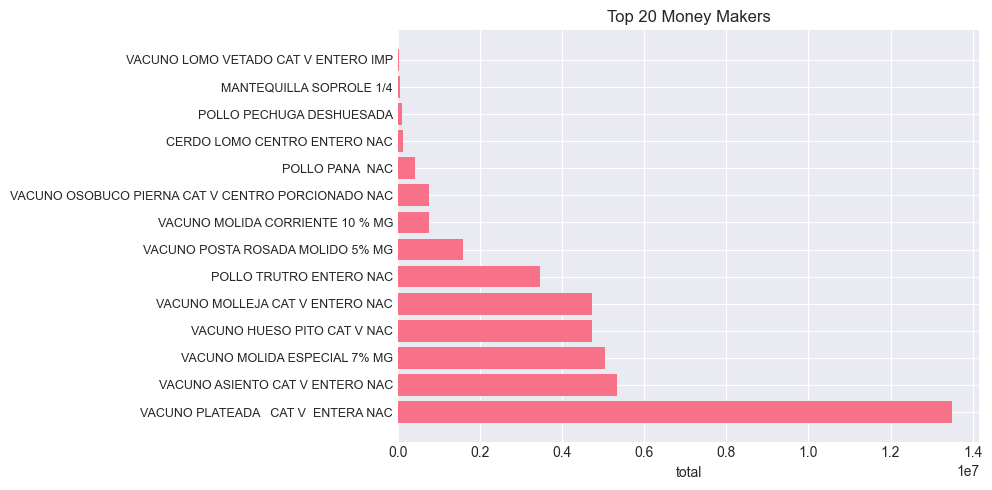

In [ ]:
# Top 20 products bar chart
top_20 = product_analysis.head(20)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.barh(range(len(top_20)), top_20[revenue_col])
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20[description_col], fontsize=9)  # Show product descriptions instead of index
ax1.set_title('Top 20 Money Makers')
ax1.set_xlabel(revenue_col)
plt.tight_layout()
plt.show()

### 2.3.3. Curva Acumulativa de la Realidad 80/20

La curva acumulativa ilustra la distribución de ingresos entre productos, enfatizando la regla 80/20. Esta visualización ayuda a comprender la concentración de ingresos.

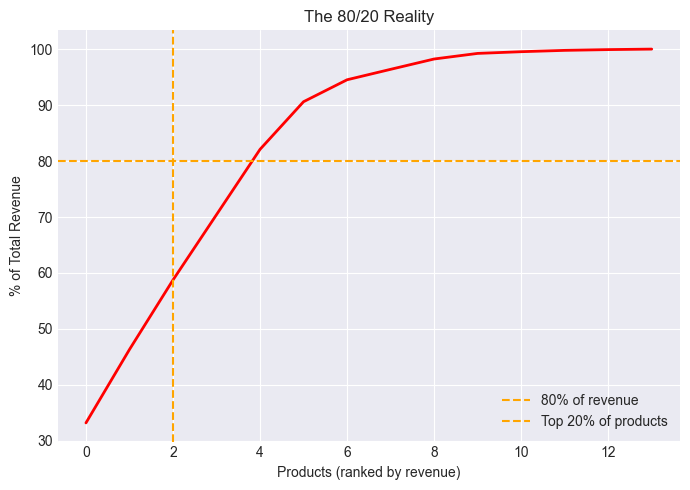

In [ ]:
# Cumulative curve
fig, ax2 = plt.subplots(figsize=(7, 5))
ax2.plot(range(len(product_analysis)), product_analysis['revenue_pct_cum'], color='red', linewidth=2)  # Curve in red
ax2.axhline(y=80, color='orange', linestyle='--', label='80% of revenue')  # Dotted line in orange
ax2.axvline(x=twenty_percent, color='orange', linestyle='--', label=f'Top 20% of products')  # Dotted line in orange
ax2.set_title('The 80/20 Reality')
ax2.set_xlabel('Products (ranked by revenue)')
ax2.set_ylabel('% of Total Revenue')
ax2.legend()
plt.tight_layout()
plt.show()

## 2.4. Alerta de Inventario Muerto

Esta sección identifica productos que no se están vendiendo bien, destacando posibles problemas de inventario. Abordar estos artículos puede liberar efectivo y espacio de almacenamiento.

### 2.4.1. ¿Qué se está acumulando polvo?

Analizar la fecha de la última venta de cada producto ayuda a identificar artículos que no se están moviendo. Estos productos pueden requerir esfuerzos promocionales o liquidación.

In [ ]:
# What's gathering dust?
last_sale = df.groupby(product_col).agg({
    date_col: 'max',
    description_col: 'first'
}).reset_index()

last_sale['days_since_sale'] = (present_dt - last_sale[date_col]).dt.days

# Add inventory value if you have it
if cost_col in df.columns and current_stock_col in df.columns:
    inventory_value = df.groupby(product_col).agg({
        cost_col: 'mean',
        current_stock_col: 'last'
    })
    last_sale = last_sale.merge(inventory_value, on=product_col)
    last_sale['tied_up_cash'] = last_sale[cost_col] * last_sale[current_stock_col]

# Categorize
last_sale['status'] = pd.cut(last_sale['days_since_sale'], 
                             bins=[0, 7, 30, 60, 90, 365, 9999],
                             labels=['Hot', 'Active', 'Slowing', 'Cold', 'Dead', 'Zombie'])

target_cols = ['glosa','days_since_sale','status']
debug_dataframe(last_sale[target_cols]) # last_sale


+----+---------------------------------+-------------------+----------+
|    | glosa                           |   days_since_sale | status   |
|----+---------------------------------+-------------------+----------|
|  0 | VACUNO ASIENTO CAT V ENTERO NAC |                19 | Active   |
|  1 | CERDO LOMO CENTRO ENTERO NAC    |                19 | Active   |
|  2 | POLLO PANA  NAC                 |                19 | Active   |
|  3 | POLLO PECHUGA DESHUESADA        |                19 | Active   |
|  4 | POLLO TRUTRO ENTERO NAC         |                19 | Active   |
+----+---------------------------------+-------------------+----------+


### 2.4.2. Verificación de Salud del Inventario

Una representación visual de la salud del inventario categoriza los productos según su actividad de ventas. Esto ayuda a priorizar acciones para diferentes grupos de productos.

💀 DEAD STOCK: 0 products haven't sold in 30+ days!


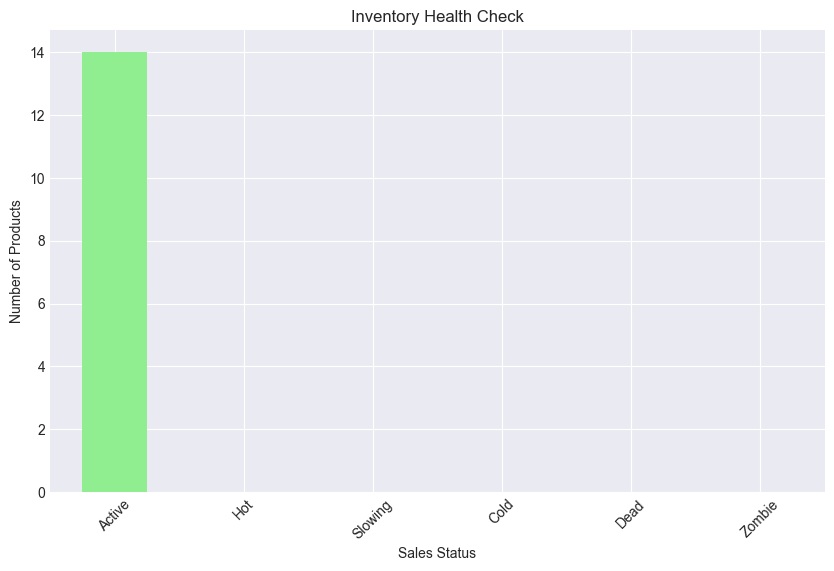

In [ ]:
dead_stock = last_sale[last_sale['days_since_sale'] > 30].sort_values('days_since_sale', ascending=False)

if 'tied_up_cash' in dead_stock.columns:
    total_dead_money = dead_stock['tied_up_cash'].sum()
    print(f"💀 DEAD MONEY ALERT: ${total_dead_money:,.0f} tied up in {len(dead_stock)} products that haven't sold in 30+ days!")
else:
    print(f"💀 DEAD STOCK: {len(dead_stock)} products haven't sold in 30+ days!")

# Visual
fig, ax = plt.subplots(figsize=(10, 6))
status_counts = last_sale['status'].value_counts()
colors = {'Hot': 'green', 'Active': 'lightgreen', 'Slowing': 'yellow', 
          'Cold': 'orange', 'Dead': 'red', 'Zombie': 'darkred'}
status_counts.plot(kind='bar', color=[colors[x] for x in status_counts.index], ax=ax)
ax.set_title('Inventory Health Check')
ax.set_ylabel('Number of Products')
ax.set_xlabel('Sales Status')
plt.xticks(rotation=45)
plt.show()

## 2.5. Mapa de Calor Día/Hora

Comprender el momento de las ventas ayuda a optimizar el personal y las horas operativas. Esta sección explora patrones de ingresos por día y hora.

### 2.5.1. Agregar Columnas de Fecha y Hora

Extraer información de fecha y hora del conjunto de datos permite un análisis temporal detallado. Este paso prepara los datos para crear un mapa de calor.

In [ ]:
# Parse 'fecha' to get just the date part
df['date_only'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce').dt.date

# Build timestamp string: 'YYYY-MM-DD HH:MM:00'
df['timestamp_str'] = df['date_only'].astype(str) + ' ' + df['inith'].astype(str).str.zfill(2) + ':' + df['initm'].astype(str).str.zfill(2) + ':00'

# Parse to datetime
df['timestamp'] = pd.to_datetime(df['timestamp_str'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
# When does money actually come in?
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
df['weekday_num'] = pd.to_datetime(df['timestamp']).dt.dayofweek


interest_cols = ['fecha','inith','initm','timestamp','hour','weekday','weekday_num','timestamp_str'] 
debug_dataframe(df[interest_cols]) # df[interest_cols]

+----+---------------------+---------+---------+---------------------+--------+-----------+---------------+---------------------+
|    | fecha               |   inith |   initm | timestamp           |   hour | weekday   |   weekday_num | timestamp_str       |
|----+---------------------+---------+---------+---------------------+--------+-----------+---------------+---------------------|
|  0 | 2018-01-02 00:00:00 |       7 |      53 | 2018-01-02 07:53:00 |      7 | Tuesday   |             1 | 2018-01-02 07:53:00 |
|  1 | 2018-01-02 00:00:00 |       7 |      53 | 2018-01-02 07:53:00 |      7 | Tuesday   |             1 | 2018-01-02 07:53:00 |
|  2 | 2018-01-02 00:00:00 |       7 |      53 | 2018-01-02 07:53:00 |      7 | Tuesday   |             1 | 2018-01-02 07:53:00 |
|  3 | 2018-01-02 00:00:00 |       7 |      53 | 2018-01-02 07:53:00 |      7 | Tuesday   |             1 | 2018-01-02 07:53:00 |
|  4 | 2018-01-02 00:00:00 |      10 |       8 | 2018-01-02 10:08:00 |     10 | Tuesday   

### 2.5.2. Visualización del Mapa de Calor

El mapa de calor resalta patrones de ingresos en diferentes días y horas. Esta visualización ayuda a identificar momentos pico y fuera de pico para las ventas.

In [ ]:
# Create heatmap data
heatmap_revenue = df.pivot_table(values=revenue_col, index='hour', columns='weekday', aggfunc='sum')
debug_dataframe(heatmap_revenue) # heatmap_revenue

+--------+-------------+
|   hour |     Tuesday |
|--------+-------------|
|      7 | 2.05893e+07 |
|     10 | 2.00194e+07 |
+--------+-------------+


⏰ TIMING INSIGHT: Peak sales on Tuesdays around 7:00
   Slowest on Mondays around 10:00


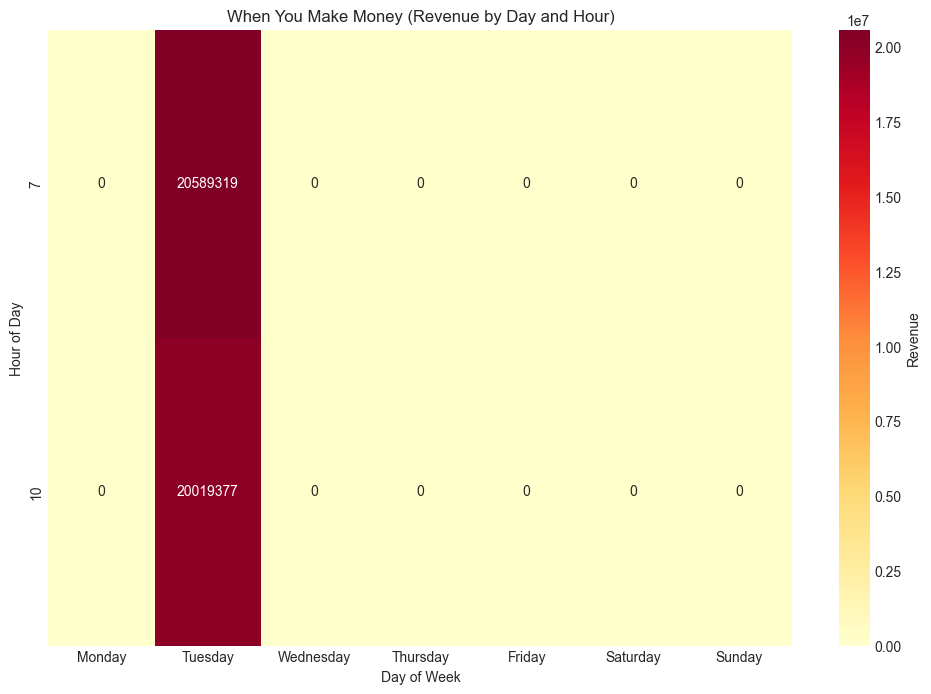

In [ ]:
# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_revenue = heatmap_revenue.reindex(columns=day_order, fill_value=0)

# Find peak and valley times
peak_day = heatmap_revenue.sum().idxmax()
peak_hour = heatmap_revenue.sum(axis=1).idxmax()
valley_day = heatmap_revenue.sum().idxmin()
valley_hour = heatmap_revenue.sum(axis=1).idxmin()

print(f"⏰ TIMING INSIGHT: Peak sales on {peak_day}s around {peak_hour}:00")
print(f"   Slowest on {valley_day}s around {valley_hour}:00")

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_revenue, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Revenue'})
plt.title('When You Make Money (Revenue by Day and Hour)')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.show()

## 2.6. Ganancia Rápida

El tablero de resumen ejecutivo consolida ideas clave y recomendaciones accionables. Esta sección proporciona una visión general de alto nivel para los tomadores de decisiones.

In [ ]:
# Executive Summary Dashboard
print("=" * 50)
print("DISTRIBUIDORA INSIGHTS SUMMARY")
print("=" * 50)
print(f"\n1. 🎯 FOCUS: Your top {twenty_percent} products generate {revenue_from_top_prcnt:.0f}% of revenue")
print(f"   → Action: Focus inventory and marketing on these winners\n")

if 'total_dead_money' in locals():
    print(f"2. 💰 CASH TRAP: ${total_dead_money:,.0f} stuck in dead inventory")
    print(f"   → Action: Liquidate these {len(dead_stock)} products ASAP\n")

print(f"3. ⏰ OPTIMAL HOURS: Peak business on {peak_day}s @ {peak_hour}:00")
print(f"   → Action: Staff accordingly, consider closing early on {valley_day}s\n")
print("=" * 50)

DISTRIBUIDORA INSIGHTS SUMMARY

1. 🎯 FOCUS: Your top 2 products generate 46% of revenue
   → Action: Focus inventory and marketing on these winners

3. ⏰ OPTIMAL HOURS: Peak business on Tuesdays @ 7:00
   → Action: Staff accordingly, consider closing early on Mondays

